# MAIA, NLP 101, Modelo Manuel

## Import Libraries

In [20]:
# Others
from __future__ import annotations
import os
import sys
import unicodedata
from typing import Iterable, List, Optional

try:
    import ftfy  # fixes mojibake/odd Unicode glitches
except Exception:
    ftfy = None


# Broad purpose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# NLP-specific
try: 
    import regex as re
except Exception:
    import re

def _get_spanish_stopwords():
    try:
        from nltk.corpus import stopwords as nltk_stopwords
        return frozenset(nltk_stopwords.words("spanish"))
    except Exception:
        # small fallback set
        return frozenset({
            "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con","no",
            "una","su","al","lo","como","más","pero","sus","le","ya","o","este","sí","porque",
            "esta","entre","cuando","muy","sin","sobre","también","me","hasta","hay","donde",
            "quien","desde","todo","nos"
        })


from functools import lru_cache

@lru_cache(maxsize=1)
def _load_spacy_es():
    try:
        import spacy
        return spacy.load("es_core_news_sm", disable=["parser", "ner", "textcat"])
    except Exception:
        return None


# Sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## Data Import

In [2]:
df_raw = pd.read_csv("../data/train.csv")
df_raw.head()

,text,decade
0,\nHonorarias ¡jubiladas. 57 \ndit.ad Pontem de...,164
1,"gone. Sus amigos , sus clientes, todo \ncuanto...",182
2,"Prefosen quemanera,e per qualesfolpechas deuan...",157
3,Caistro el M a y o r a i .] Del ape...,163
4,\nlos que panden macho ; y \notros en l...,166


In [3]:
# Creamos una copia del dataframe
df = df_raw.copy()

## Exploratory Analysis

In [4]:
# Ver algunos ejemplos de texto
df['text'][3]

'Caistro  el  M  a  y  o  r  a  i  .]  Del  apellido  de  Cañroíe \nvalió  Don  Luis  enefta.  Metáfora, para  el  nombre  que  fupo \nne  de  Caiftro.  Mayoral  fe  llama  entre  los  ganaderos  el \nque  tiene  el  primer  lugar,  y  a  quien  efián  fujetos  los  de¬ \nmas, y  defia  mayoría  tomó  el  nombte. '

In [5]:
# Tamaño del dataset
df.shape

(31403, 2)

In [6]:
# Datos vacíos
df.isna().sum()

text      0
decade    0
dtype: int64

In [7]:
# Datos repetidos
df.duplicated(subset=['text']).sum()

np.int64(51)

In [8]:
df.drop_duplicates(subset=['text'], inplace=True)

print(df.shape)

(31352, 2)


There are 39 unique decades


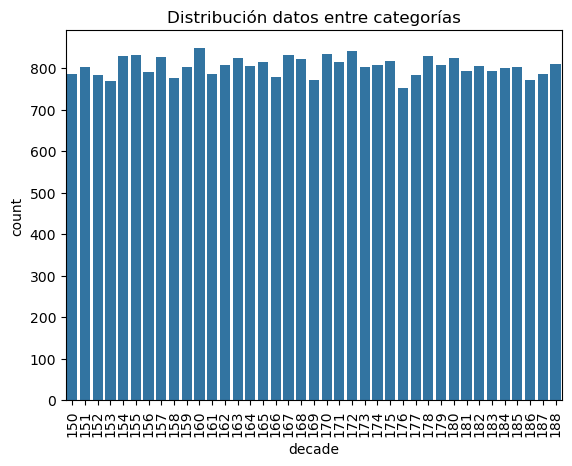

In [9]:
# Distribución de datos en décadas
print("There are " + str(len(df['decade'].unique())) + " unique decades")

# Visual de la distribución
sns.barplot(df.decade.value_counts())
plt.title("Distribución datos entre categorías")
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing

In [10]:
_PUNCT_TO_SPACE = str.maketrans({c: " " for c in r"""!?"#%&'()*+,./:;<=>@[\]^_`{|}~¡¿"""})
_NEGATIONS = frozenset({"no", "nunca", "jamás", "ni", "sin"})

class NoRefTextNormalizer(BaseEstimator, TransformerMixin):
    """
    Deterministic Spanish text normalizer suitable for sklearn Pipelines and parallel GridSearch.
    - No external helper functions referenced (avoids Windows/joblib pickling issues in notebooks)
    - Does not keep non-picklable objects on self
    - Optional stopword removal (keeps negations), optional stemming/lemmatization (lazy per call)
    """
    def __init__(self,
                 lowercase: bool = True,
                 strip_accents: bool = True,
                 remove_punct: bool = True,
                 normalize_numbers: bool = True,
                 dehyphenate_lines: bool = True,
                 collapse_whitespace: bool = True,
                 remove_stopwords: bool = True,
                 lemmatize: bool = False,   # set True only if spaCy es_core_news_sm is installed
                 stem: bool = False,        # good fallback when lemmatize=False
                 min_token_len: int = 2):
        self.lowercase = lowercase
        self.strip_accents = strip_accents
        self.remove_punct = remove_punct
        self.normalize_numbers = normalize_numbers
        self.dehyphenate_lines = dehyphenate_lines
        self.collapse_whitespace = collapse_whitespace
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.stem = (stem and not lemmatize)
        self.min_token_len = min_token_len

        # Build a picklable stopword set (Spanish); keep negations
        sw = set()
        if remove_stopwords:
            try:
                from nltk.corpus import stopwords as _sw  # loaded per process
                sw = set(_sw.words("spanish"))
            except Exception:
                sw = {
                    "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con",
                    "una","su","al","lo","como","más","pero","sus","le","ya","o","este","sí","porque",
                    "esta","entre","cuando","muy","sin","sobre","también","me","hasta","hay","donde",
                    "quien","desde","todo","nos","eso","esa","ese","estos","estas","muy"
                }
        self._stopwords = frozenset(sw - _NEGATIONS)

        # Token pattern (letters only); uses `regex` if available for \p{L}
        self._token_pattern = r"\b\p{L}+\b" if "regex" in sys.modules else r"[A-Za-zÀ-ÿ]+"

    @staticmethod
    def _strip_accents(t: str) -> str:
        nfkd = unicodedata.normalize("NFKD", t)
        return "".join(ch for ch in nfkd if not unicodedata.combining(ch))

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._one(t) for t in X]

    def _one(self, text: str) -> str:
        if not isinstance(text, str):
            text = "" if text is None else str(text)

        # De-hyphenate across line breaks and squash control whitespace
        if self.dehyphenate_lines:
            text = re.sub(r"(\w)[\--]\s*\n\s*(\w)", r"\1\2", text)
        text = re.sub(r"[\r\n\t]+", " ", text)

        if self.lowercase:
            text = text.lower()

        if self.normalize_numbers:
            text = re.sub(r"\b\d{1,}\b", " <NUM> ", text)

        if self.strip_accents:
            text = self._strip_accents(text)

        if self.remove_punct:
            text = text.translate(_PUNCT_TO_SPACE)

        # Light tokenization
        toks = re.findall(self._token_pattern, text)

        # Stopwords & min length
        if self.remove_stopwords or self.min_token_len > 1:
            toks = [t for t in toks if (t not in self._stopwords) and (len(t) >= self.min_token_len)]

        # Optional lemmatize or stem: created locally (not stored on self)
        if self.lemmatize:
            try:
                import spacy
                nlp = spacy.load("es_core_news_sm", disable=["parser", "ner", "textcat"])
                doc = nlp(" ".join(toks))
                toks = [tok.lemma_ or tok.text for tok in doc]
                toks = [t for t in toks if (t not in self._stopwords) and (len(t) >= self.min_token_len)]
            except Exception:
                pass
        elif self.stem:
            try:
                from nltk.stem.snowball import SnowballStemmer
                stemmer = SnowballStemmer("spanish")
                toks = [stemmer.stem(t) for t in toks]
            except Exception:
                pass

        out = " ".join(toks).strip()
        return re.sub(r"\s{2,}", " ", out)


In [11]:
test_df = df.copy().iloc[0:5 , 0]

In [12]:
normalizer = NoRefTextNormalizer(
    remove_stopwords=True,
    lemmatize=False,
    stem=True,
    min_token_len=2
)


test_norm = normalizer.fit_transform(test_df)

test_norm

['honorari jubil num dit ad pontem poreft proreg num num num num pag num num num ste ph grati difcept num aqu len nes parec aisilt ayud calsiodor lib num epuft num llam oclos cingv num',
 'gon amig client cuant rode prueb hombr much import si ve hombr plebey fuerz servici hazan elev clas nac consuel dic puus lles nr hxe iju todavi necesit famili anos antigued',
 'pref quemaner per qualesfolpech deu feratorment qui preguntasl deu haz mientr tormentarf vecl lstitopuz',
 'caistr apell canroi vali don luis eneft metafor nombr fup ne caiftr mayoral fe llam ganader prim lug efi fujet mas defi mayori tom nombt',
 'pand mach fu na abund cia iiempr viu mendig lan aun edit fagr compit sol luzimieut pues dos llam moy fes aftros clarid fupsnor no dand ellreliaeft precrogatiu viclt dsus da laminari magn si fe atiend dcmonilr ma temat lun tol mayor quemercuri nor dem aftrossdifpu eflb aparient viabl mas oftentof ojos hombr fe licu estim aun eftil dios mas luz atefor dem afirosjper no muef tant pues 

## Model Training

In [13]:
# Split train and test datasets
X = df["text"].astype(str)
y = df["decade"]

# Robust split: use stratify only when each class has >=2 samples
_can_stratify = (y.nunique() > 1) and (y.value_counts().min() >= 2)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if _can_stratify else None
)


In [14]:
X_train = normalizer.fit_transform(X_train_raw)
X_test  = normalizer.transform(X_test_raw)

In [15]:
pipe = Pipeline([
    ("prep", normalizer),
    ("tfidf", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 2),
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(max_iter=200))
])

# Grid (you can expand this or pass multiple grids as we discussed)
param_distributions = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [2, 4],
    "tfidf__max_df": [0.9, 1.0],
    # Use a tiny discrete set for speed; swap for C_dist if you imported loguniform
    "clf__C": [0.1, 1.0, 3.0],
    "clf__class_weight": [None, "balanced"],
}

rs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=8,            
    cv=2,                
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro",
    random_state=42
)

rs.fit(X_train_raw, y_train)

print("Best params:", rs.best_params_)
print("Best CV score:", rs.best_score_)
best_model = rs.best_estimator_

# Ready for evaluation or next steps:
X_test = X_test_raw  # raw texts (the pipeline contains the normalizer)
y_test = y_test
print(f"Train N={len(X_train_raw)}, Test N={len(X_test)}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best params: {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_df': 1.0, 'clf__class_weight': None, 'clf__C': 3.0}
Best CV score: 0.1849182573710627
Train N=25081, Test N=6271


In [16]:
pd.DataFrame(rs.cv_results_).sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__ngram_range,param_tfidf__min_df,param_tfidf__max_df,param_clf__class_weight,param_clf__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,93.918237,4.345536,22.400101,2.504775,"(1, 2)",2,1.0,None,3.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__min_df'...",0.185634,0.184203,0.184918,0.000715,1
1,64.038911,6.637644,43.643364,5.981934,"(1, 1)",2,0.9,balanced,3.0,"{'tfidf__ngram_range': (1, 1), 'tfidf__min_df'...",0.182462,0.178385,0.180423,0.002039,2
3,53.389890,5.583256,51.728879,4.711506,"(1, 2)",4,0.9,balanced,3.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__min_df'...",0.182119,0.178140,0.180129,0.001989,3
7,54.418359,3.257093,52.017199,3.751692,"(1, 2)",4,0.9,None,1.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__min_df'...",0.174670,0.175139,0.174904,0.000235,4
0,41.078239,6.644014,60.805152,5.840247,"(1, 2)",4,0.9,balanced,1.0,"{'tfidf__ngram_range': (1, 2), 'tfidf__min_df'...",0.174769,0.173687,0.174228,0.000541,5
4,46.435392,1.904928,55.241253,0.300776,"(1, 1)",2,0.9,balanced,1.0,"{'tfidf__ngram_range': (1, 1), 'tfidf__min_df'...",0.173205,0.173424,0.173314,0.000110,6
2,33.964947,1.521061,63.642667,1.216215,"(1, 1)",4,0.9,balanced,1.0,"{'tfidf__ngram_range': (1, 1), 'tfidf__min_df'...",0.172439,0.173610,0.173025,0.000586,7
6,32.801508,6.838355,58.610991,1.948358,"(1, 1)",2,1.0,balanced,0.1,"{'tfidf__ngram_range': (1, 1), 'tfidf__min_df'...",0.143693,0.136129,0.139911,0.003782,8


### Model Evaluation

In [18]:
y_pred = best_model.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         150      0.601     0.643     0.622       157
         151      0.319     0.463     0.378       160
         152      0.528     0.484     0.505       157
         153      0.310     0.429     0.360       154
         154      0.423     0.512     0.463       166
         155      0.218     0.162     0.186       167
         156      0.272     0.278     0.275       158
         157      0.159     0.176     0.167       165
         158      0.208     0.226     0.217       155
         159      0.227     0.325     0.267       160
         160      0.092     0.076     0.084       170
         161      0.106     0.096     0.101       157
         162      0.150     0.149     0.150       161
         163      0.100     0.079     0.088       165
         164      0.121     0.106     0.113       161
         165      0.110     0.110     0.110       163
         166      0.074     0.051     0.061       156
         167      0.115    

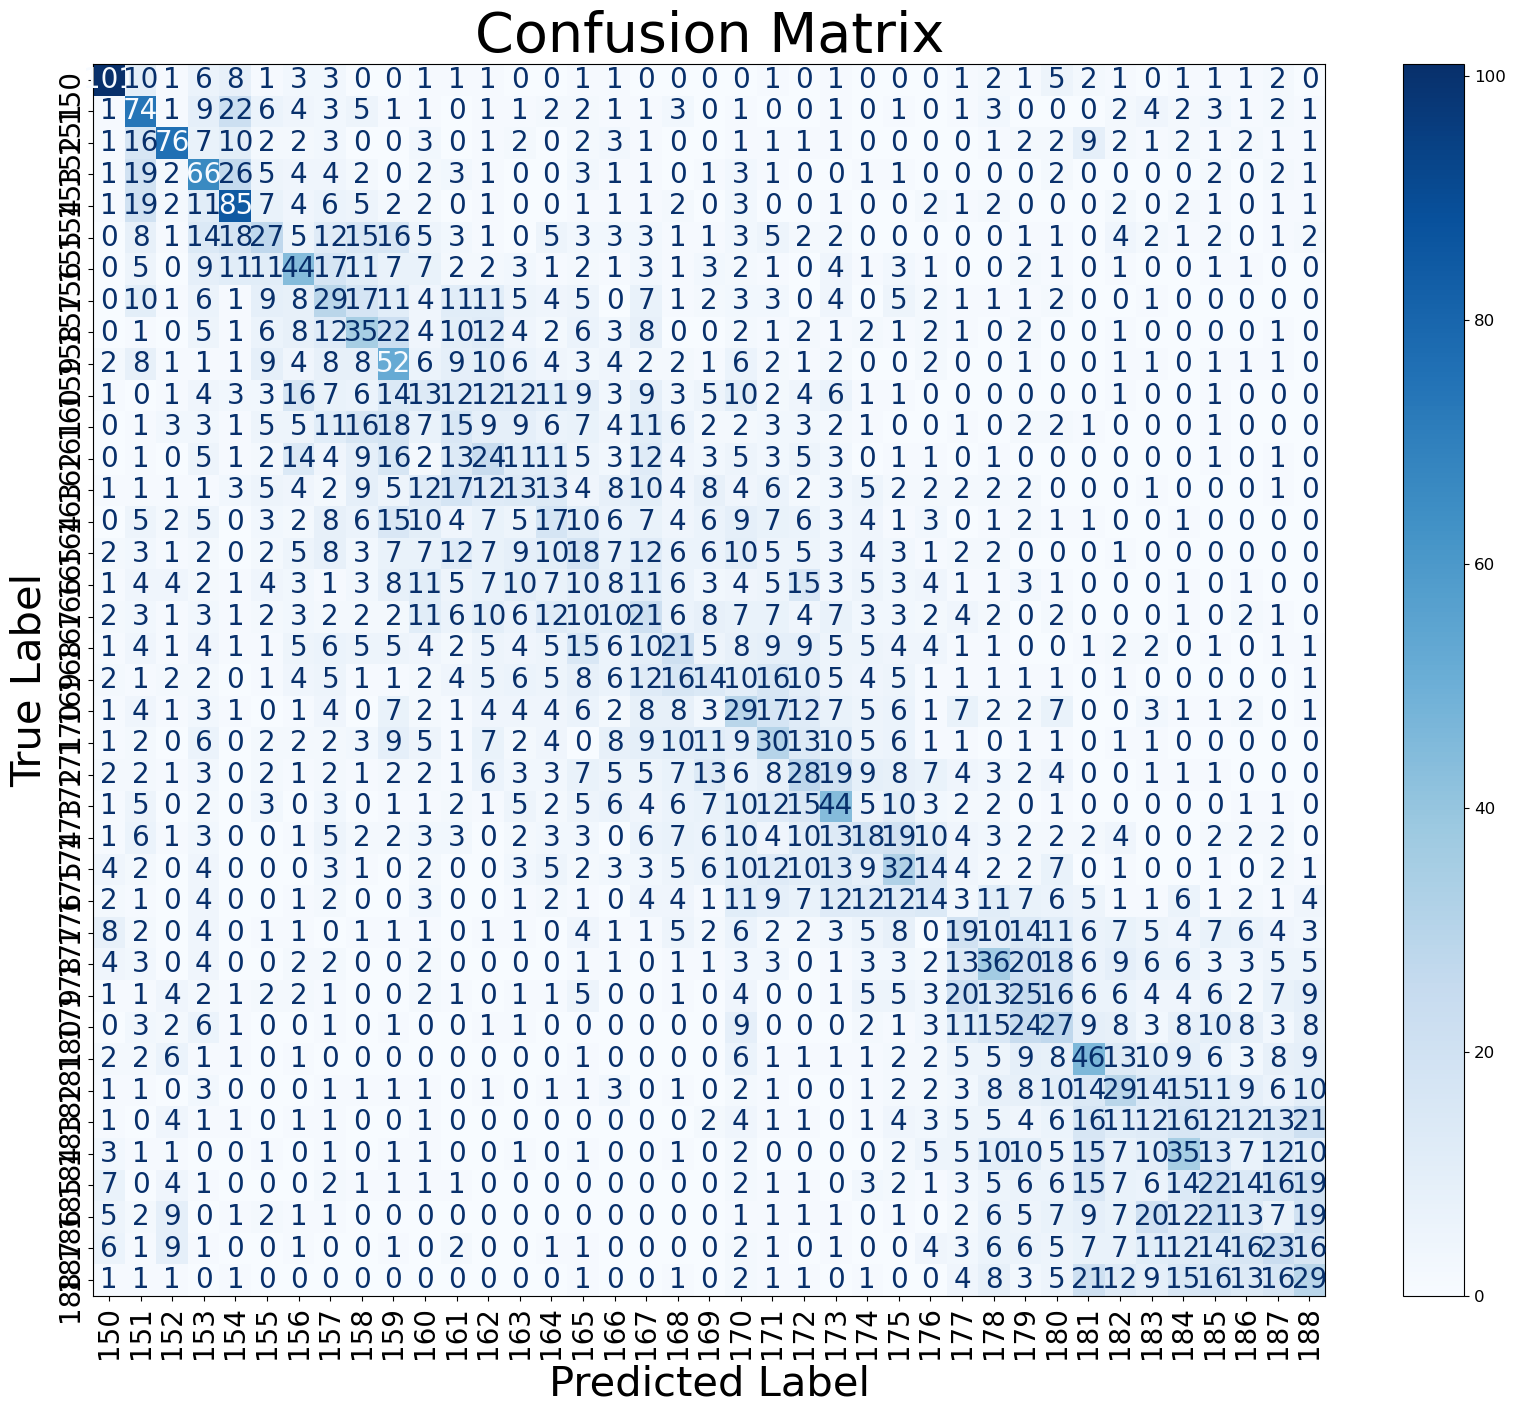

In [ ]:
# Assume cm is already defined with your data
# cm = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=best_model.classes_)

# Create a figure and axes object with a specific size
fig, ax = plt.subplots(figsize=(20, 16))

# Plot the confusion matrix directly onto the specified axes
cm.plot(ax=ax, cmap='Blues', values_format='d')

# Manually adjust the font sizes of other elements for clarity
ax.set_title("Confusion Matrix", fontsize=40)
ax.set_xlabel("Predicted Label", fontsize=30)
ax.set_ylabel("True Label", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)

# To adjust the font size of the numbers inside the cells
for text in ax.texts:
    text.set_fontsize(20)

plt.show()

In [ ]:
import numpy as np, pandas as pd
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

print("y_train size:", len(y_train))
print("Classes:", len(set(y_train)))
print("Top-10 label counts:", Counter(y_train).most_common(10))

# Baseline using most frequent class (to gauge difficulty)
most_common = Counter(y_train).most_common(1)[0][0]
y_pred_dummy = np.full_like(y_test, fill_value=most_common)
print(classification_report(y_test, y_pred_dummy, digits=3))

y_train size: 25081
Classes: 39
Top-10 label counts: [(160, 678), (172, 673), (170, 666), (155, 665), (167, 665), (178, 664), (157, 662), (154, 662), (163, 660), (180, 659)]
              precision    recall  f1-score   support

         150      0.000     0.000     0.000       157
         151      0.000     0.000     0.000       160
         152      0.000     0.000     0.000       157
         153      0.000     0.000     0.000       154
         154      0.000     0.000     0.000       166
         155      0.000     0.000     0.000       167
         156      0.000     0.000     0.000       158
         157      0.000     0.000     0.000       165
         158      0.000     0.000     0.000       155
         159      0.000     0.000     0.000       160
         160      0.027     1.000     0.053       170
         161      0.000     0.000     0.000       157
         162      0.000     0.000     0.000       161
         163      0.000     0.000     0.000       165
         164   

c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\meeb1\anaconda3\envs\venv_learn\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r